Datasets used: 
- `Law School Success` :<br>
The dataset was originally collected for a study called 'LSAC National Longitudinal Bar Passage Study'. It includes background information and if (and how) candidates passed the bar exam to become lawyers/legal practicioners in the USA<br>

    Important Variables:
    
    gender: Gender of the student.<br>
    lsat: LSAT score received by the student.<br>
    pass_bar: Ground truth label indicating whether or not the student eventually passed the bar.<br>
    race: Race of the student.<br>
    gpa: A student's undergraduate GPA.<br>

Reference Links: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
from aif360.sklearn.datasets import fetch_adult
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
sensitive_attribute = "gender"

## Load Dataset

In [3]:
DATAFILE= "bar_pass_prediction.csv"

#learning_class_weights = {0: 50, 1: 5}

X = pd.read_csv(DATAFILE)
#Drop unnecessary features
X = X.drop(columns=['sex','dnn_bar_pass_prediction','ID','bar_passed','race',
                    'race2','decile1b','decile3','decile1','asian','black','hisp','other','index6040','bar1','bar2','DOB_yr','male','bar','indxgrp','indxgrp2','grad'
                    ,'bar1_yr','bar2_yr','parttime','age','cluster','zgpa','fulltime','fam_inc','Dropout','tier','gpa','pass_bar'])
num_features = X._get_numeric_data().columns.to_list()

df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()
df = df.dropna()
df = df.reset_index(drop=True)

df.head()

,lsat,ugpa,zfygpa,gender,race1
0,44.0,3.5,1.33,female,white
1,29.0,3.5,-0.11,female,white
2,36.0,3.5,-0.64,male,white
3,39.0,3.5,0.34,male,white
4,48.0,3.5,1.02,male,white


In [4]:
df.zfygpa = np.where(df.zfygpa >= df.zfygpa.median(),1,0)

In [5]:
df.head()

,lsat,ugpa,zfygpa,gender,race1
0,44.0,3.5,1,female,white
1,29.0,3.5,0,female,white
2,36.0,3.5,0,male,white
3,39.0,3.5,1,male,white
4,48.0,3.5,1,male,white


## Model training and test

In [6]:
X = df.drop('zfygpa', axis=1)
y = df['zfygpa']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [7]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='labels')
model.predict(X_test.iloc[:100, :])

Wall time: 463 ms


array([0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.])

In [8]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57      3206
           1       0.59      0.70      0.64      3216

    accuracy                           0.61      6422
   macro avg       0.61      0.61      0.61      6422
weighted avg       0.61      0.61      0.61      6422



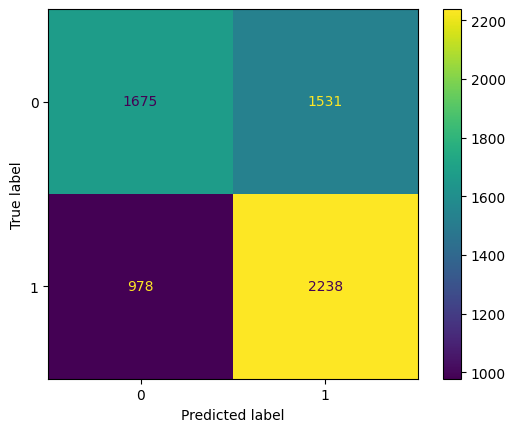

In [9]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [11]:
for col in cate_features:
    X_test[col] = X_test[col].astype('object')

In [12]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
     X_test,
     model=model,
     sensitive_attribute='gender',
     missing_subgroup_val="Unknown"
 )

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:00<00:00, 33.81it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 2/2 [00:00<00:00, 501.38it/s]

Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.



100%|██████████| 83/83 [00:00<00:00, 2455.72it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 939/939 [00:09<00:00, 97.70it/s] 

Number of if-thens: 939


In [12]:
#### Uncomment if you wish to load rules object from disk

import dill

with open("rulesLawSchool.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [13]:
#### Uncomment if you wish to save rules object on disk

import dill

with open("rulesLawSchool.data", "wb") as outf:
     dill.dump(rules_by_if, outf)

In [13]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["male"][1][0][1]-e[1]["female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If ugpa = 2.3:
	Subgroup 'female', 1.56% covered
		Make ugpa = 3.4 with correctness 25.00%.
		Make ugpa = 3.6 with correctness 30.00%.
		Make ugpa = 3.5 with correctness 25.00%.
		Make ugpa = 3.3 with correctness 25.00%.
		Make ugpa = 3.7 with correctness 30.00%.
		Make ugpa = 3.2 with correctness 20.00%.
		Make ugpa = 3.1 with correctness 20.00%.
		Make ugpa = 3.8 with correctness 30.00%.
		Make ugpa = 3.0 with correctness 15.00%.
		Make ugpa = 3.9 with correctness 30.00%.
		Make ugpa = 2.9 with correctness 15.00%.
		Make ugpa = 2.8 with correctness 10.00%.
		Make ugpa = 2.7 with correctness 5.00%.
		Make ugpa = 2.6 with correctness 5.00%.
	Subgroup 'male', 2.77% covered
		Make ugpa = 3.4 with correctness 60.53%.
		Make ugpa = 3.6 with correctness 63.16%.
		Make ugpa = 3.5 with correctness 63.16%.
		Make ugpa = 3.3 with correctness 50.00%.
		Make ugpa = 3.7 with correctness 63.16%.
		Make ugpa = 3.2 with correctness 47.37%.
		Make ugpa = 3.1 with correctness 44.74%.
		Make ugpa = 3.8 

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [14]:
feature_weights = {"gender": 1, "race1": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [15]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If race1 = black, ugpa = 2.7:
	Subgroup 'female', 1.09% covered out of 9331
		Make race1 = white, ugpa = 3.4 with correctness 14.29%.
		Make race1 = white, ugpa = 3.6 with correctness 21.43%.
		Make race1 = white, ugpa = 3.3 with correctness 14.29%.
		Make race1 = white, ugpa = 3.5 with correctness 21.43%.
		Make race1 = white, ugpa = 3.7 with correctness 28.57%.
		Make race1 = white, ugpa = 3.1 with correctness 0.00%.
		Make race1 = white, ugpa = 3.8 with correctness 28.57%.
		Make race1 = white, ugpa = 3.0 with correctness 0.00%.
		Make race1 = white, ugpa = 3.9 with correctness 35.71%.
		Make race1 = white, ugpa = 2.9 with correctness 0.00%.
		Make race1 = white, ugpa = 2.8 with correctness 0.00%.
		Make race1 = white with correctness 0.00%.
		Make race1 = white, ugpa = 2.6 with correctness 0.00%.
		Aggregate cost of the above recourses = -0.25
	Subgroup 'male', 1.09% covered out of 12075
		Make race1 = white, ugpa = 3.4 with correctness 46.67%.
		Make race1 = white, ugpa = 3.6 with

## Minimum cost above threshold

In [16]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If ugpa = 3.3:
	Subgroup 'female', 9.06% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.63% covered out of 12075
		Make ugpa = 3.8 with correctness 51.65%.
		Make ugpa = 3.9 with correctness 59.34%.
		Aggregate cost of the above recourses = 1.00
	Bias against female. Unfairness measure = inf.
If ugpa = 2.8:
	Subgroup 'female', 6.33% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 9.47% covered out of 12075
		Make ugpa = 3.6 with correctness 50.77%.
		Make ugpa = 3.7 with correctness 53.85%.
		Make ugpa = 3.8 with correctness 56.92%.
		Make ugpa = 3.9 with correctness 60.77%.
		Aggregate cost of the above recourses = 1.00
	Bias against female. Unfairness measure = inf.
If ugpa = 2.5:
	Subgroup 'female', 3.83% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 5.32% covered out of 

## Mean cost above threshold

In [17]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If ugpa = 3.3:
	Subgroup 'female', 9.06% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.63% covered out of 12075
		Make ugpa = 3.8 with correctness 51.65%.
		Make ugpa = 3.9 with correctness 59.34%.
		Aggregate cost of the above recourses = 1.00
	Bias against female. Unfairness measure = inf.
If ugpa = 2.8:
	Subgroup 'female', 6.33% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 9.47% covered out of 12075
		Make ugpa = 3.6 with correctness 50.77%.
		Make ugpa = 3.7 with correctness 53.85%.
		Make ugpa = 3.8 with correctness 56.92%.
		Make ugpa = 3.9 with correctness 60.77%.
		Aggregate cost of the above recourses = 1.00
	Bias against female. Unfairness measure = inf.
If ugpa = 2.5:
	Subgroup 'female', 3.83% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 5.32% covered out of 

## Number above threshold

In [18]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If lsat = 28.0:
	Subgroup 'female', 3.67% covered out of 9331
		Make lsat = 45.0 with correctness 53.19%.
		Make lsat = 46.0 with correctness 53.19%.
		Make lsat = 47.0 with correctness 55.32%.
		Make lsat = 48.0 with correctness 55.32%.
		Aggregate cost of the above recourses = -4.00
	Subgroup 'male', 4.15% covered out of 12075
		Make lsat = 39.0 with correctness 54.39%.
		Make lsat = 40.0 with correctness 54.39%.
		Make lsat = 37.0 with correctness 52.63%.
		Make lsat = 42.0 with correctness 59.65%.
		Make lsat = 38.0 with correctness 54.39%.
		Make lsat = 41.0 with correctness 57.89%.
		Make lsat = 44.0 with correctness 61.40%.
		Make lsat = 43.0 with correctness 61.40%.
		Make lsat = 45.0 with correctness 63.16%.
		Make lsat = 46.0 with correctness 64.91%.
		Make lsat = 47.0 with correctness 66.67%.
		Make lsat = 48.0 with correctness 68.42%.
		Aggregate cost of the above recourses = -12.00
	Bias against female. Unfairness measure = 8.
If lsat = 29.0:
	Subgroup 'female', 4.06% cove

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [20]:
import dill

with open("stateLawSchool.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OneHotEncoder from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LabelEncoder from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


If race1 = black, ugpa = 2.7:
	Subgroup 'female', 1.09% covered out of 9331
		Make race1 = white, ugpa = 3.4 with correctness 14.29%.
		Make race1 = white, ugpa = 3.6 with correctness 21.43%.
		Make race1 = white, ugpa = 3.3 with correctness 14.29%.
		Make race1 = white, ugpa = 3.5 with correctness 21.43%.
		Make race1 = white, ugpa = 3.7 with correctness 28.57%.
		Make race1 = white, ugpa = 3.1 with correctness 0.00%.
		Make race1 = white, ugpa = 3.8 with correctness 28.57%.
		Make race1 = white, ugpa = 3.0 with correctness 0.00%.
		Make race1 = white, ugpa = 3.9 with correctness 35.71%.
		Make race1 = white, ugpa = 2.9 with correctness 0.00%.
		Make race1 = white, ugpa = 2.8 with correctness 0.00%.
		Make race1 = white with correctness 0.00%.
		Make race1 = white, ugpa = 2.6 with correctness 0.00%.
	Subgroup 'male', 1.09% covered out of 12075
		Make race1 = white, ugpa = 3.4 with correctness 46.67%.
		Make race1 = white, ugpa = 3.6 with correctness 73.33%.
		Make race1 = white, ugpa 

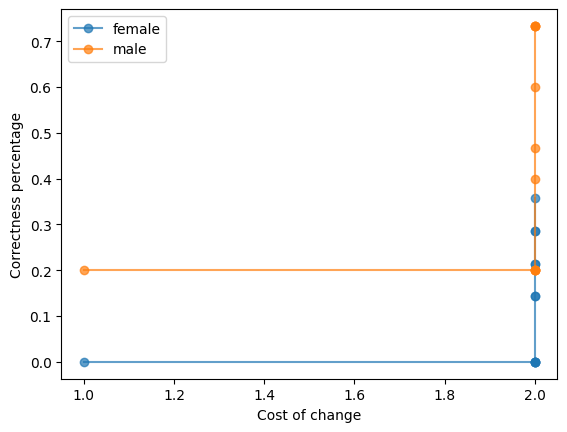

If race1 = black, ugpa = 2.9:
	Subgroup 'female', 2.11% covered out of 9331
		Make race1 = white, ugpa = 3.4 with correctness 18.52%.
		Make race1 = white, ugpa = 3.6 with correctness 37.04%.
		Make race1 = white, ugpa = 3.3 with correctness 18.52%.
		Make race1 = white, ugpa = 3.5 with correctness 29.63%.
		Make race1 = white, ugpa = 3.7 with correctness 44.44%.
		Make race1 = white, ugpa = 3.1 with correctness 11.11%.
		Make race1 = white, ugpa = 3.8 with correctness 44.44%.
		Make race1 = white, ugpa = 3.0 with correctness 3.70%.
		Make race1 = white, ugpa = 3.9 with correctness 48.15%.
		Make race1 = white with correctness 3.70%.
		Make race1 = white, ugpa = 2.8 with correctness 3.70%.
		Make race1 = white, ugpa = 2.7 with correctness 3.70%.
		Make race1 = white, ugpa = 2.6 with correctness 0.00%.
	Subgroup 'male', 1.09% covered out of 12075
		Make race1 = white, ugpa = 3.4 with correctness 40.00%.
		Make race1 = white, ugpa = 3.6 with correctness 53.33%.
		Make race1 = white, ugpa

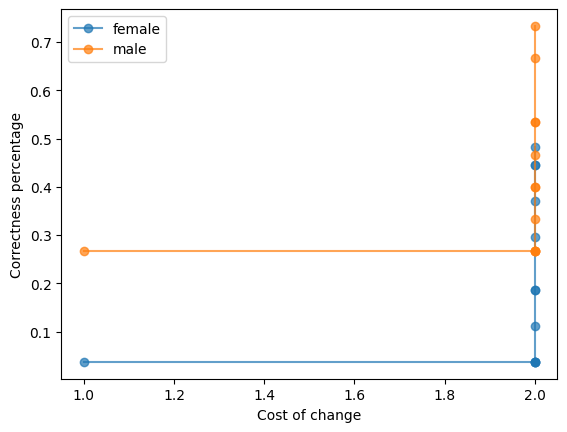

If lsat = 35.0, ugpa = 2.9:
	Subgroup 'female', 1.09% covered out of 9331
		Make lsat = 37.0, ugpa = 3.4 with correctness 71.43%.
		Make lsat = 37.0, ugpa = 3.1 with correctness 71.43%.
		Make lsat = 39.0, ugpa = 3.4 with correctness 71.43%.
		Make lsat = 42.0, ugpa = 3.5 with correctness 85.71%.
		Make lsat = 39.0, ugpa = 3.6 with correctness 71.43%.
		Make ugpa = 3.4 with correctness 71.43%.
		Make lsat = 36.0, ugpa = 3.2 with correctness 71.43%.
		Make lsat = 40.0, ugpa = 3.4 with correctness 71.43%.
		Make lsat = 37.0, ugpa = 3.5 with correctness 71.43%.
	Subgroup 'male', 1.75% covered out of 12075
		Make lsat = 37.0, ugpa = 3.4 with correctness 87.50%.
		Make lsat = 37.0, ugpa = 3.1 with correctness 87.50%.
		Make lsat = 39.0, ugpa = 3.4 with correctness 87.50%.
		Make lsat = 42.0, ugpa = 3.5 with correctness 91.67%.
		Make lsat = 39.0, ugpa = 3.6 with correctness 91.67%.
		Make ugpa = 3.4 with correctness 87.50%.
		Make lsat = 36.0, ugpa = 3.2 with correctness 87.50%.
		Make lsat

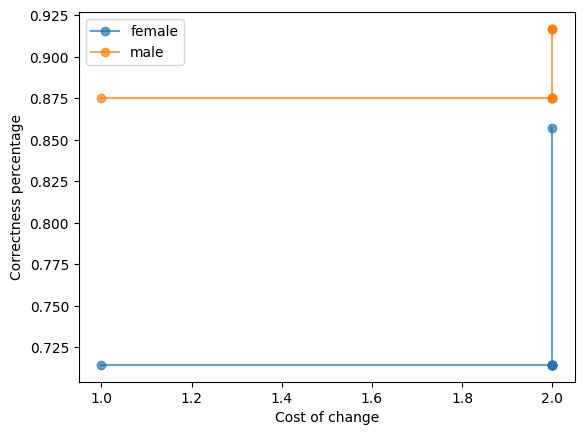

If ugpa = 2.5:
	Subgroup 'female', 3.83% covered out of 9331
		Make ugpa = 3.4 with correctness 26.53%.
		Make ugpa = 3.6 with correctness 32.65%.
		Make ugpa = 3.5 with correctness 32.65%.
		Make ugpa = 3.3 with correctness 26.53%.
		Make ugpa = 3.7 with correctness 34.69%.
		Make ugpa = 3.2 with correctness 24.49%.
		Make ugpa = 3.1 with correctness 20.41%.
		Make ugpa = 3.8 with correctness 34.69%.
		Make ugpa = 3.0 with correctness 18.37%.
		Make ugpa = 3.9 with correctness 38.78%.
		Make ugpa = 2.9 with correctness 18.37%.
		Make ugpa = 2.8 with correctness 14.29%.
		Make ugpa = 2.7 with correctness 4.08%.
		Make ugpa = 2.6 with correctness 0.00%.
	Subgroup 'male', 5.32% covered out of 12075
		Make ugpa = 3.4 with correctness 57.53%.
		Make ugpa = 3.6 with correctness 64.38%.
		Make ugpa = 3.5 with correctness 58.90%.
		Make ugpa = 3.3 with correctness 49.32%.
		Make ugpa = 3.7 with correctness 65.75%.
		Make ugpa = 3.2 with correctness 49.32%.
		Make ugpa = 3.1 with correctness 4

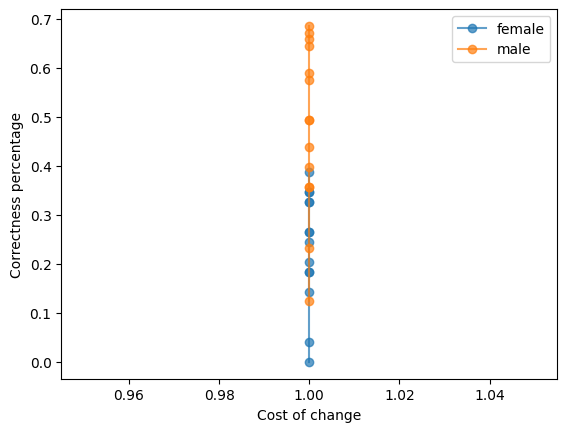

If ugpa = 2.3:
	Subgroup 'female', 1.56% covered out of 9331
		Make ugpa = 3.4 with correctness 25.00%.
		Make ugpa = 3.6 with correctness 30.00%.
		Make ugpa = 3.5 with correctness 25.00%.
		Make ugpa = 3.3 with correctness 25.00%.
		Make ugpa = 3.7 with correctness 30.00%.
		Make ugpa = 3.2 with correctness 20.00%.
		Make ugpa = 3.1 with correctness 20.00%.
		Make ugpa = 3.8 with correctness 30.00%.
		Make ugpa = 3.0 with correctness 15.00%.
		Make ugpa = 3.9 with correctness 30.00%.
		Make ugpa = 2.9 with correctness 15.00%.
		Make ugpa = 2.8 with correctness 10.00%.
		Make ugpa = 2.7 with correctness 5.00%.
		Make ugpa = 2.6 with correctness 5.00%.
	Subgroup 'male', 2.77% covered out of 12075
		Make ugpa = 3.4 with correctness 60.53%.
		Make ugpa = 3.6 with correctness 63.16%.
		Make ugpa = 3.5 with correctness 63.16%.
		Make ugpa = 3.3 with correctness 50.00%.
		Make ugpa = 3.7 with correctness 63.16%.
		Make ugpa = 3.2 with correctness 47.37%.
		Make ugpa = 3.1 with correctness 4

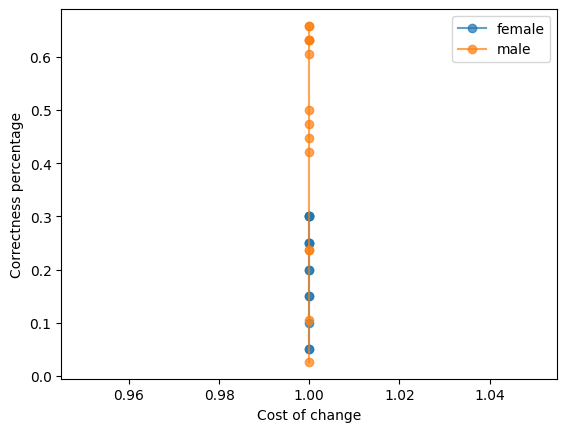

If race1 = hisp, ugpa = 2.9:
	Subgroup 'female', 1.02% covered out of 9331
		Make race1 = white, ugpa = 3.4 with correctness 23.08%.
		Make race1 = white, ugpa = 3.6 with correctness 23.08%.
		Make race1 = white, ugpa = 3.3 with correctness 23.08%.
		Make race1 = white, ugpa = 3.5 with correctness 23.08%.
		Make race1 = white, ugpa = 3.7 with correctness 30.77%.
		Make race1 = white, ugpa = 3.1 with correctness 15.38%.
		Make race1 = white, ugpa = 3.8 with correctness 30.77%.
		Make race1 = white, ugpa = 3.0 with correctness 15.38%.
		Make race1 = white, ugpa = 3.9 with correctness 30.77%.
		Make race1 = white with correctness 15.38%.
		Make race1 = white, ugpa = 2.8 with correctness 15.38%.
		Make race1 = white, ugpa = 2.7 with correctness 15.38%.
		Make race1 = white, ugpa = 2.6 with correctness 7.69%.
	Subgroup 'male', 1.02% covered out of 12075
		Make race1 = white, ugpa = 3.4 with correctness 42.86%.
		Make race1 = white, ugpa = 3.6 with correctness 42.86%.
		Make race1 = white, u

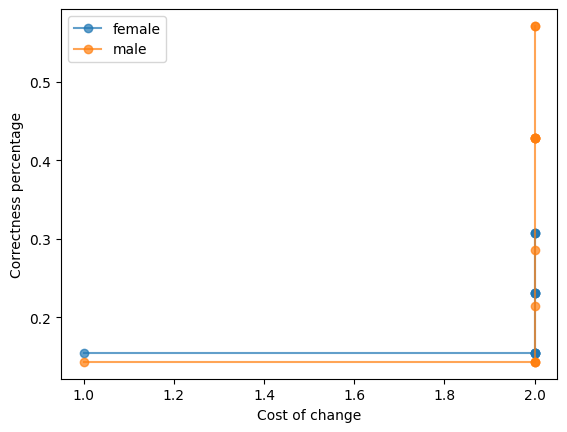

If race1 = white, ugpa = 2.5:
	Subgroup 'female', 1.88% covered out of 9331
		Make ugpa = 3.4 with correctness 54.17%.
		Make ugpa = 3.6 with correctness 66.67%.
		Make ugpa = 3.3 with correctness 54.17%.
		Make ugpa = 3.5 with correctness 66.67%.
		Make ugpa = 3.7 with correctness 70.83%.
		Make ugpa = 3.1 with correctness 41.67%.
		Make ugpa = 3.8 with correctness 70.83%.
		Make ugpa = 3.0 with correctness 37.50%.
		Make ugpa = 3.9 with correctness 79.17%.
		Make ugpa = 2.9 with correctness 37.50%.
		Make ugpa = 2.8 with correctness 29.17%.
		Make ugpa = 2.7 with correctness 8.33%.
		Make ugpa = 2.6 with correctness 0.00%.
	Subgroup 'male', 3.64% covered out of 12075
		Make ugpa = 3.4 with correctness 84.00%.
		Make ugpa = 3.6 with correctness 94.00%.
		Make ugpa = 3.3 with correctness 72.00%.
		Make ugpa = 3.5 with correctness 86.00%.
		Make ugpa = 3.7 with correctness 94.00%.
		Make ugpa = 3.1 with correctness 64.00%.
		Make ugpa = 3.8 with correctness 96.00%.
		Make ugpa = 3.0 wit

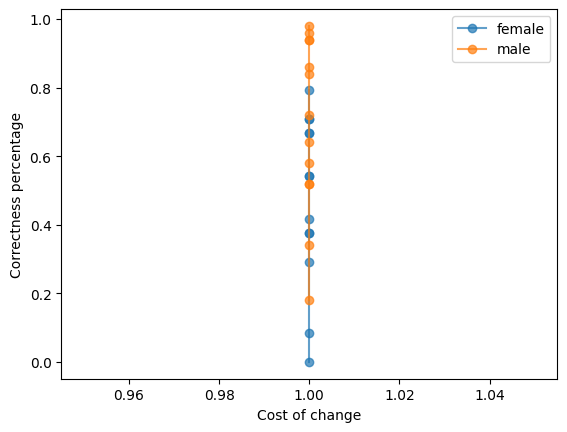

If lsat = 29.0:
	Subgroup 'female', 4.06% covered out of 9331
		Make lsat = 39.0 with correctness 38.46%.
		Make lsat = 40.0 with correctness 40.38%.
		Make lsat = 37.0 with correctness 26.92%.
		Make lsat = 42.0 with correctness 44.23%.
		Make lsat = 38.0 with correctness 38.46%.
		Make lsat = 41.0 with correctness 40.38%.
		Make lsat = 36.0 with correctness 23.08%.
		Make lsat = 44.0 with correctness 50.00%.
		Make lsat = 43.0 with correctness 48.08%.
		Make lsat = 35.0 with correctness 23.08%.
		Make lsat = 45.0 with correctness 53.85%.
		Make lsat = 34.0 with correctness 11.54%.
		Make lsat = 46.0 with correctness 53.85%.
		Make lsat = 47.0 with correctness 55.77%.
		Make lsat = 48.0 with correctness 55.77%.
		Make lsat = 33.0 with correctness 9.62%.
	Subgroup 'male', 4.08% covered out of 12075
		Make lsat = 39.0 with correctness 58.93%.
		Make lsat = 40.0 with correctness 60.71%.
		Make lsat = 37.0 with correctness 55.36%.
		Make lsat = 42.0 with correctness 64.29%.
		Make lsat = 

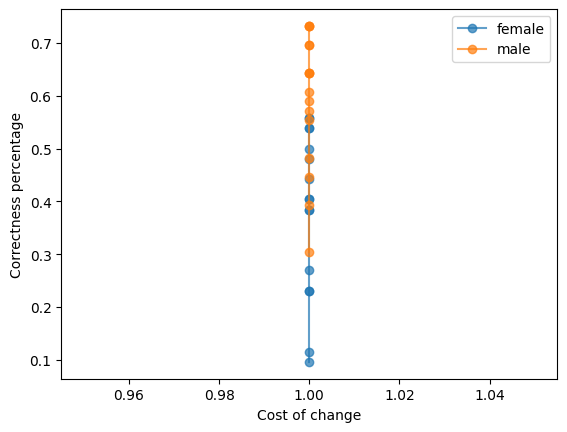

If lsat = 33.0, ugpa = 3.1:
	Subgroup 'female', 1.17% covered out of 9331
		Make lsat = 37.0, ugpa = 3.4 with correctness 73.33%.
		Make lsat = 37.0 with correctness 73.33%.
		Make lsat = 39.0, ugpa = 3.4 with correctness 73.33%.
		Make lsat = 42.0, ugpa = 3.5 with correctness 73.33%.
		Make lsat = 39.0, ugpa = 3.6 with correctness 73.33%.
		Make lsat = 35.0, ugpa = 3.4 with correctness 73.33%.
		Make lsat = 36.0, ugpa = 3.2 with correctness 73.33%.
		Make lsat = 40.0, ugpa = 3.4 with correctness 73.33%.
		Make lsat = 37.0, ugpa = 3.5 with correctness 73.33%.
	Subgroup 'male', 1.60% covered out of 12075
		Make lsat = 37.0, ugpa = 3.4 with correctness 81.82%.
		Make lsat = 37.0 with correctness 81.82%.
		Make lsat = 39.0, ugpa = 3.4 with correctness 81.82%.
		Make lsat = 42.0, ugpa = 3.5 with correctness 86.36%.
		Make lsat = 39.0, ugpa = 3.6 with correctness 86.36%.
		Make lsat = 35.0, ugpa = 3.4 with correctness 81.82%.
		Make lsat = 36.0, ugpa = 3.2 with correctness 81.82%.
		Make ls

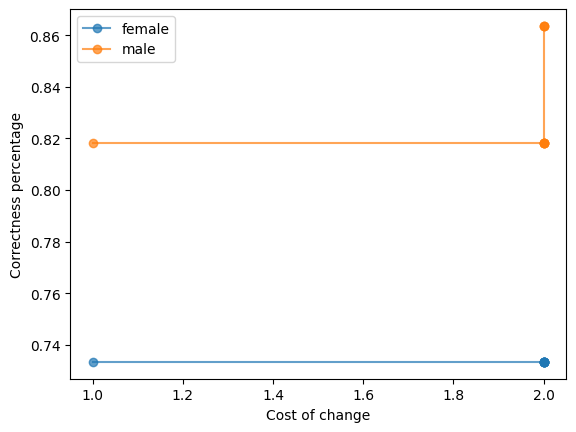

If lsat = 28.0:
	Subgroup 'female', 3.67% covered out of 9331
		Make lsat = 39.0 with correctness 38.30%.
		Make lsat = 40.0 with correctness 38.30%.
		Make lsat = 37.0 with correctness 31.91%.
		Make lsat = 42.0 with correctness 42.55%.
		Make lsat = 38.0 with correctness 36.17%.
		Make lsat = 41.0 with correctness 38.30%.
		Make lsat = 36.0 with correctness 29.79%.
		Make lsat = 44.0 with correctness 48.94%.
		Make lsat = 43.0 with correctness 44.68%.
		Make lsat = 35.0 with correctness 23.40%.
		Make lsat = 45.0 with correctness 53.19%.
		Make lsat = 34.0 with correctness 19.15%.
		Make lsat = 46.0 with correctness 53.19%.
		Make lsat = 47.0 with correctness 55.32%.
		Make lsat = 48.0 with correctness 55.32%.
		Make lsat = 33.0 with correctness 12.77%.
	Subgroup 'male', 4.15% covered out of 12075
		Make lsat = 39.0 with correctness 54.39%.
		Make lsat = 40.0 with correctness 54.39%.
		Make lsat = 37.0 with correctness 52.63%.
		Make lsat = 42.0 with correctness 59.65%.
		Make lsat =

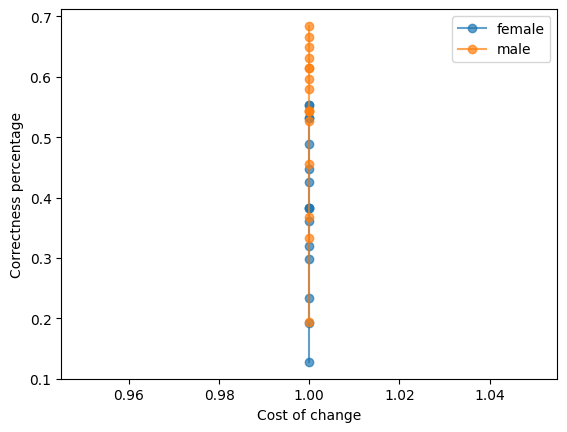

In [19]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="weighted-average",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute=sensitive_attribute)

pop_sizes = {sg: (df[sensitive_attribute] == sg).sum() for sg in df[sensitive_attribute].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [22]:
import dill

with open("stateLawSchool.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)